### Get going by asking the following questions and looking for the answers with some code and plots:
    Can you count something interesting?
    Can you find some trends (high, low, increase, decrease, anomalies)?
    Can you make a bar plot or a histogram?
    Can you compare two related quantities?
    Can you make a scatterplot?
    Can you make a time-series plot?

### Having made these plots:
    What are some insights you get from them? 
    Do you see any correlations? 
    Is there a hypothesis you would like to investigate further? 
    What other questions do they lead you to ask?

### By now you’ve asked a bunch of questions, and found some neat insights. 
    Is there an interesting narrative, a way of presenting the insights using text and plots from the above, 
        that tells a compelling story? 
    As you work out this story, what are some other trends/relationships you think will make it more complete?



In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob

import seaborn as sns
sns.set()


## Load Trip Data Sets

In [2]:
print('Loading data...')
try:

    file_path_slug = '../../datasets/bayareabikeshare/*_trip_data.csv'

    # glob all files
    file_list = glob(file_path_slug)

    trips = pd.DataFrame()

    counter = 1
    chunks = []
    for file in file_list:
        print('\nReading file [' + str(counter) + ' of ' + str(len(file_list)) + ']\t ' + str(file))

        # import file in chunks to temp DataFrame
        print('\treading chunks...')
        for chunk in pd.read_csv(file, chunksize=10000, iterator=True):

            chunk = chunk.set_index('Trip ID')

            # standardize column names - 201402 dataset uses 'Subscription Type' in place of 'Subscriber Type'
            chunk.columns = ['Duration', 'Start Date', 'Start Station', 'Start Terminal', 'End Date', 
                             'End Station', 'End Terminal', 'Bike #', 'Subscriber Type', 'Zip Code']

            chunks.append(chunk)

        print('\tfinished file!')
        counter += 1

    # status = pd.concat(chunks, ignore_index=True)
    trips = pd.concat(chunks)


    print('data loaded successfully!')
except:
    print('oops... something went wrong loading the data :(')


Loading data...

Reading file [1 of 4]	 ../../datasets/bayareabikeshare/201608_trip_data.csv
	reading chunks...
	finished file!

Reading file [2 of 4]	 ../../datasets/bayareabikeshare/201402_trip_data.csv
	reading chunks...
	finished file!

Reading file [3 of 4]	 ../../datasets/bayareabikeshare/201508_trip_data.csv
	reading chunks...
	finished file!

Reading file [4 of 4]	 ../../datasets/bayareabikeshare/201408_trip_data.csv
	reading chunks...
	finished file!
data loaded successfully!


### initial exploration

In [3]:
trips.head(10)

,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Bike #,Subscriber Type,Zip Code
Trip ID,,,,,,,,,,
913465,746,9/1/2015 0:10,San Francisco Caltrain 2 (330 Townsend),69,9/1/2015 0:23,San Francisco City Hall,58,238,Subscriber,94107
913466,969,9/1/2015 0:15,Clay at Battery,41,9/1/2015 0:31,Washington at Kearny,46,16,Subscriber,94133
913467,233,9/1/2015 0:15,Davis at Jackson,42,9/1/2015 0:19,Commercial at Montgomery,45,534,Subscriber,94111
913468,213,9/1/2015 1:29,Clay at Battery,41,9/1/2015 1:32,Steuart at Market,74,312,Subscriber,94107
913469,574,9/1/2015 1:33,Steuart at Market,74,9/1/2015 1:42,San Francisco Caltrain 2 (330 Townsend),69,279,Subscriber,94107
913470,623,9/1/2015 1:36,San Jose Diridon Caltrain Station,2,9/1/2015 1:47,Japantown,9,261,Subscriber,95112
913471,746,9/1/2015 2:15,Embarcadero at Bryant,54,9/1/2015 2:27,Powell Street BART,39,436,Subscriber,94103
913472,1038,9/1/2015 3:38,Townsend at 7th,65,9/1/2015 3:56,Howard at 2nd,63,607,Subscriber,94107
913473,424,9/1/2015 4:23,Market at 10th,67,9/1/2015 4:30,Townsend at 7th,65,259,Subscriber,94102


In [4]:
len(trips.index)

983648

In [5]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983648 entries, 913465 to 198776
Data columns (total 10 columns):
Duration           983648 non-null int64
Start Date         983648 non-null object
Start Station      983648 non-null object
Start Terminal     983648 non-null int64
End Date           983648 non-null object
End Station        983648 non-null object
End Terminal       983648 non-null int64
Bike #             983648 non-null int64
Subscriber Type    983648 non-null object
Zip Code           976838 non-null object
dtypes: int64(4), object(6)
memory usage: 82.6+ MB


In [6]:
trips.describe()

,Duration,Start Terminal,End Terminal,Bike #
count,9.836480e+05,983648.000000,983648.000000,983648.000000
mean,1.018932e+03,58.121022,58.100089,423.319779
std,1.841684e+04,16.841133,16.912386,158.071344
min,6.000000e+01,2.000000,2.000000,9.000000
25%,3.470000e+02,50.000000,50.000000,328.000000
50%,5.180000e+02,62.000000,62.000000,437.000000
75%,7.480000e+02,70.000000,70.000000,544.000000
max,1.727040e+07,91.000000,91.000000,878.000000


## Lets clean up the data set a bit

In [7]:
print('Data cleanup started...')

#   cleanup column names
print('\tcleaning up column names...')
new_cols = []
for col in trips.columns:
    new_col = col.replace(' ', '_').lower()
    new_cols.append(new_col)
trips.columns = new_cols

#   extract columns we want to keep
print('Subsetting to useful columns...')
important_cols = ['duration', 'start_date', 'start_terminal', 'end_date', 'end_terminal', 'bike_#', 'subscriber_type', 'zip_code']
trips = trips[important_cols]


#   create duration_minutes column
trips['duration_minutes'] = trips['duration'] / 60.

#   convert end and start dates to datetime objects
print('\tconverting end and start dates to datetime objects...')
trips['start_date'] = pd.to_datetime(trips['start_date'], format="%m/%d/%Y %H:%M")
trips['end_date'] = pd.to_datetime(trips['end_date'], format="%m/%d/%Y %H:%M")
print('\t\tfinished!')

#   create a start and end hour trip column
print('\tcreating start and end hour columns...')
trips['start_hour'] = trips['start_date'].dt.hour
trips['end_hour'] = trips['end_date'].dt.hour
print('\t\tfinished!')

# convert zip codes to numeric
# trips['zip_code'] = pd.to_numeric(trips['zip_code'], errors='coerce')
trips['zip_code'] = trips['zip_code'].astype(str)

print('\tfinished!')

Data cleanup started...
	cleaning up column names...
Subsetting to useful columns...
	converting end and start dates to datetime objects...
		finished!
	creating start and end hour columns...
		finished!
	finished!


In [8]:
def clean_zipcode(item):
    if len(item) != 5:

        # split on '-'
        try:
            result = item.split('-')[0]
        except:
            result = item

        # split on '.'
        try:
            result = item.split('.')[0]
        except:
            result = item
        
        # if len of item is less than 5, return 'NaN'
        if len(result) < 5:
            result = 'NaN'
        else:
            # if len result is greater than 5, take at most, first 5 digits
            result = result[:5]
    else:
        result = item
    
    # make sure result is all digits
    if result.isdigit():
        return result
    else:
        return 'NaN'

trips.zip_code = trips.zip_code.apply(clean_zipcode)
trips['zip_code'] = pd.to_numeric(trips['zip_code'], errors='coerce')


In [9]:
# look at unique values in each column
print('#' * 80)
print('#\tColumns and unique values')
detail_cols = ['start_terminal', 'end_terminal', 'bike_#', 'subscriber_type', 'zip_code']
for col in detail_cols:
    print('Column : ' + col + '\t' + str(len(pd.unique(trips[col]))))
    print(np.sort(pd.unique(trips[col])))
#     print(pd.unique(trips[col]))
    print()

################################################################################
#	Columns and unique values
Column : start_terminal	74
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 16 21 22 23 24 25 26 27 28 29 30 31
 32 33 34 35 36 37 38 39 41 42 45 46 47 48 49 50 51 54 55 56 57 58 59 60 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 80 82 83 84 88 89 90 91]

Column : end_terminal	74
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 16 21 22 23 24 25 26 27 28 29 30 31
 32 33 34 35 36 37 38 39 41 42 45 46 47 48 49 50 51 54 55 56 57 58 59 60 61
 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 80 82 83 84 88 89 90 91]

Column : bike_#	700
[  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26
  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62
  63  64  65  66  67  68  69  70  71  72  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99


In [10]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983648 entries, 913465 to 198776
Data columns (total 11 columns):
duration            983648 non-null int64
start_date          983648 non-null datetime64[ns]
start_terminal      983648 non-null int64
end_date            983648 non-null datetime64[ns]
end_terminal        983648 non-null int64
bike_#              983648 non-null int64
subscriber_type     983648 non-null object
zip_code            945782 non-null float64
duration_minutes    983648 non-null float64
start_hour          983648 non-null int64
end_hour            983648 non-null int64
dtypes: datetime64[ns](2), float64(2), int64(6), object(1)
memory usage: 90.1+ MB


## Initial Visual investigation

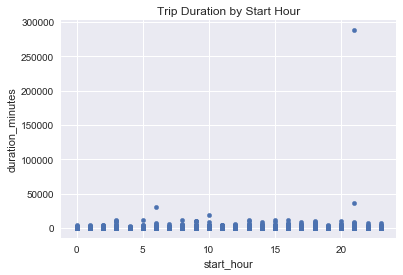

In [11]:
trips.plot(kind='scatter', x='start_hour', y='duration_minutes')
plt.title('Trip Duration by Start Hour')
plt.xlabel='Start Hour'
plt.ylabel='Duration in Minutes'
plt.show()

Whoa... we have found a pretty significant outlier in this data set, someone had a bike for nearly 300,000 minutes (that is near 200 days!) and we also see some trips that are nearing 50,000 minutes (roughly 34 days).  

Lets first remove the largest outlier and take a look at a histogram of ride duration to see the spread of the data.

	pruning data to trips no more than 35 days long...
		pruned data set 'trips' consists of 983647 entries


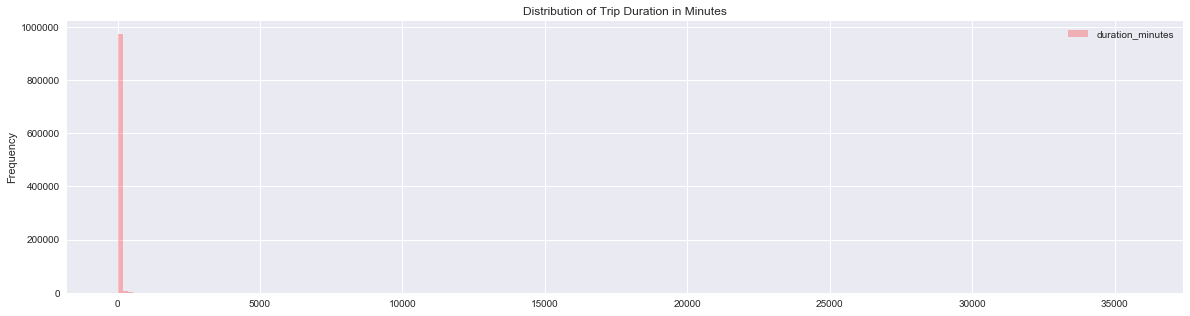

In [12]:
# our data set show duration in seconds, here are some handy conversions
second = 1
minute = second * 60
hour = minute * 60
day = hour * 24

# prune data to exclude trips longer than 35 days
print('\tpruning data to trips no more than 35 days long...')
trips = trips[trips['duration'] <= 35 * day].copy()
print('\t\tpruned data set \'trips\' consists of %i entries' % len(trips.index))

# plot histogram of trip duration
trips['duration_minutes'].plot(kind='hist', color='r', alpha=0.25, bins=200, figsize=(20,5))
plt.title('Distribution of Trip Duration in Minutes')
plt.xlabel='Trip Duration (Minutes)'
plt.ylabel='Number of Trips'
plt.legend(loc='best')
plt.show()

Looks like we still have a pretty wide spread, next lets drill into trips that are no more than than 1000 minutes long and see what that distribution looks like.

	pruning data to trips no more than 1000 minutes long...
		pruned data set 'trips' consists of 982667 entries


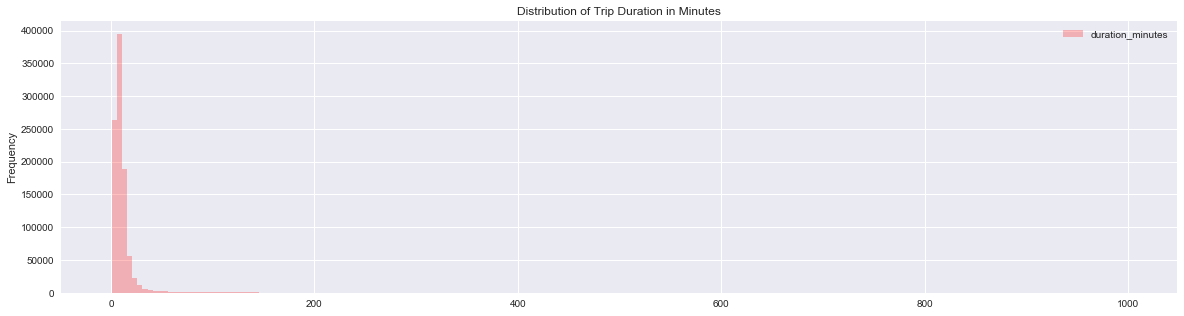

In [13]:
# prune data to exclude trips longer than 1000 minutes
print('\tpruning data to trips no more than 1000 minutes long...')
trips = trips[trips['duration'] <= 1000 * minute].copy()
print('\t\tpruned data set \'trips\' consists of %i entries' % len(trips.index))

# plot histogram of trip duration
trips['duration_minutes'].plot(kind='hist', color='r', alpha=0.25, bins=200, figsize=(20,5))
plt.title('Distribution of Trip Duration in Minutes')
plt.xlabel='Trip Duration (Minutes)'
plt.ylabel='Number of Trips'
plt.legend(loc='best')
plt.show()

Getting closer, lets prune down to just trips no more than 200 minutes, that looks like it will show all the data and leave some breathing room

	pruning data to trips no more than 200 minutes long...
		pruned data set 'trips' consists of 974342 entries


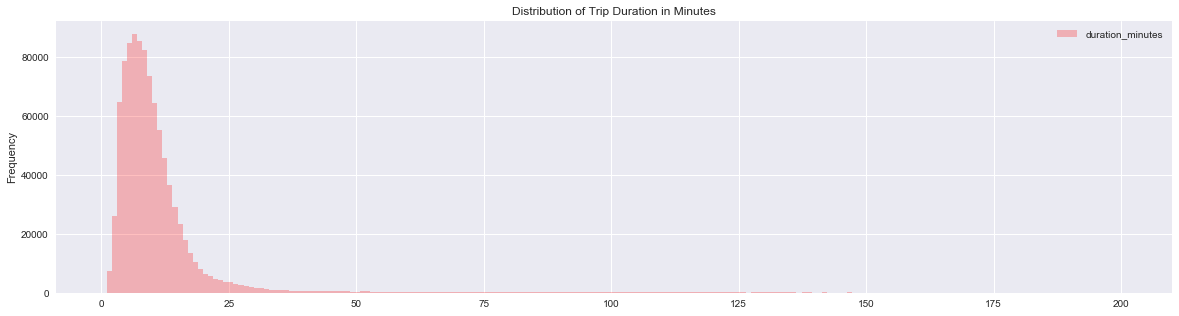

In [14]:
# prune data to exclude trips longer than 200 minutes
print('\tpruning data to trips no more than 200 minutes long...')
trips = trips[trips['duration'] <= 200 * minute].copy()
print('\t\tpruned data set \'trips\' consists of %i entries' % len(trips.index))

# plot histogram of trip duration
trips['duration_minutes'].plot(kind='hist', color='r', alpha=0.25, bins=200, figsize=(20,5))
plt.title('Distribution of Trip Duration in Minutes')
plt.xlabel='Trip Duration (Minutes)'
plt.ylabel='Number of Trips'
plt.legend(loc='best')
plt.show()

heck, lets just go for it, it seems that the vast majority of trips are less than 35 minutes, lets just take a look at the distribution of those trips

	pruning data to trips no more than 35 minutes long...
		pruned data set 'trips' consists of 942712 entries


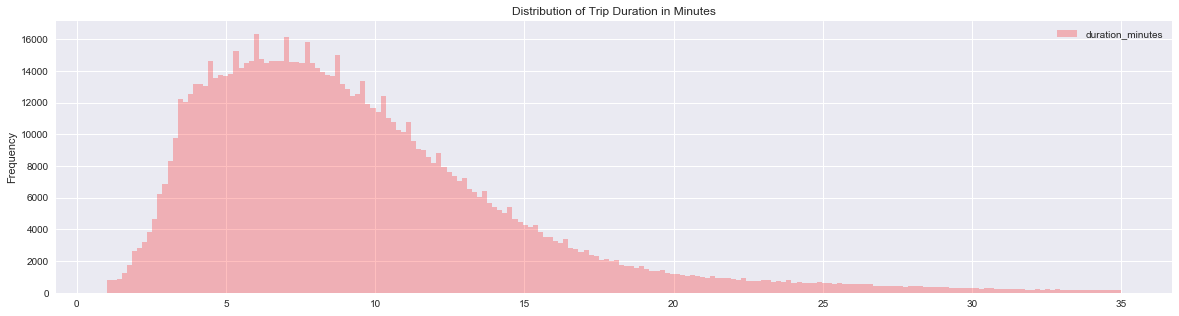

In [15]:
# prune data to exclude trips longer than 35 minutes
print('\tpruning data to trips no more than 35 minutes long...')
trips = trips[trips['duration'] <= 35 * minute].copy()
print('\t\tpruned data set \'trips\' consists of %i entries' % len(trips.index))

# plot histogram of trip duration
trips['duration_minutes'].plot(kind='hist', color='r', alpha=0.25, bins=200, figsize=(20,5))
plt.title('Distribution of Trip Duration in Minutes')
plt.xlabel='Trip Duration (Minutes)'
plt.ylabel='Number of Trips'
plt.legend(loc='best')
plt.show()

Much better! And look, after pruning the original 983648 trips down to just trips no more than 35 minutes long, we still have 942712 trips, so we are looking at 95.8% of the data.

## Deeper Investigation of Data

now that we have a good grasp of the 'important' data. Lets see if we can find any interesting trends.

### Number of rides by hour of the day

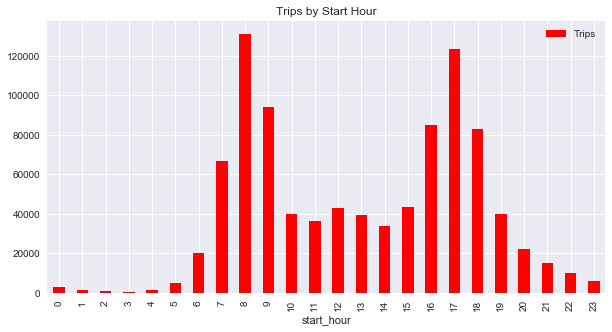

In [16]:
# plot trip duration by start hour
trips.groupby(['start_hour'])['duration_minutes'].count().plot(kind='bar', color='r', figsize=(10,5))

plt.title('Trips by Start Hour')
plt.xlabel='Start Hour'
plt.legend(['Trips'],loc='best')
plt.show()

Now this is interesting, it looks like there are distinct spikes in rides starting during commute hours.  Seeing as a lot of cummuters would start and end their trips at different terminals, lets see if there is a difference in trips that start and end at different terminals ('one ways') vs trips that start and end at the same terminal ('round trips').

## One Way and Round Trips

In [17]:
print('Pruning a DataFrame of one way trips...')
one_way_trips = trips.loc[trips['start_terminal'] != trips['end_terminal']].copy()
print('\tpruned data set now consists of %i lines' % len(one_way_trips.index))

print('Pruning a DataFrame of round trips...')
round_trips = trips.loc[trips.loc[:,'start_terminal'] == trips.loc[:,'end_terminal']].copy()
print('\tpruned data set now consists of %i lines' % len(round_trips.index))

Pruning a DataFrame of one way trips...
	pruned data set now consists of 926110 lines
Pruning a DataFrame of round trips...
	pruned data set now consists of 16602 lines


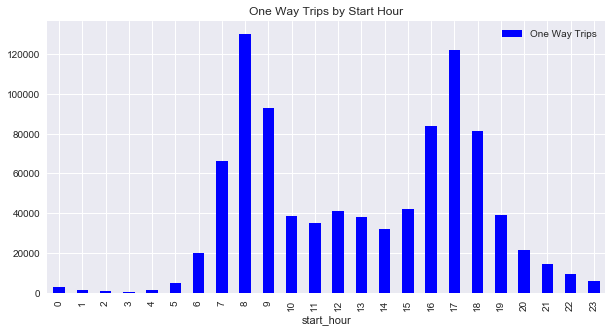

In [18]:
# plot trip duration by start hour
one_way_trips.groupby(['start_hour'])['duration_minutes'].count().plot(kind='bar', color='b', figsize=(10,5))
plt.title('One Way Trips by Start Hour')
plt.xlabel='Start Hour'
plt.legend(['One Way Trips'],loc='best')
plt.show()

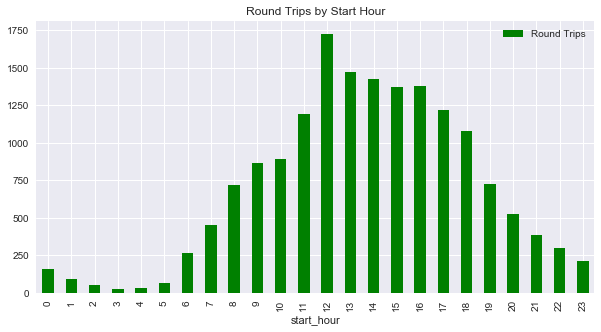

In [19]:
round_trips.groupby(['start_hour'])['duration_minutes'].count().plot(kind='bar', color='g', figsize=(10,5))
plt.title('Round Trips by Start Hour')
plt.xlabel='Start Hour'
plt.legend(['Round Trips'],loc='best')
plt.show()

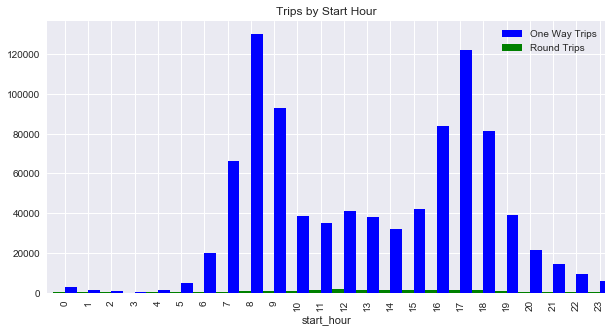

In [20]:
# plot trip duration by start hour
ax = one_way_trips.groupby(['start_hour'])['duration_minutes'].count().plot(kind='bar',position=0, color='b', figsize=(10,5))
round_trips.groupby(['start_hour'])['duration_minutes'].count().plot(kind='bar',position=1, color='g', ax=ax)
plt.title('Trips by Start Hour')
plt.xlabel='Start Hour'
plt.legend(['One Way Trips', 'Round Trips'],loc='best')
plt.show()

We can see from these three graphs that there are definite spikes in usage during commute hours and that this is nearly all from one way trips.  Separating out the round trip rides, these are mostly taken during waking hours and even have a noticable spike around lunch hours.

All together, it is easy to see that the VAST majority of rides taken are one way trips.

### Next Hypotheis: 

Looks like we have a lot of one way trips in commute hours, and more round trips during waking hours, even a noteworthy peak right around lunch time!  Next we are going to trip down the data sets again to only include trips to and from stations within San Francisco.

In [21]:
# station ID numbers that are in San Francisco
sf_stations = [ 39,41,42,45,46,47,48,49,50,51,54,55,56,57,58,59,60,61,62,63,
                64,65,66,67,68,69,70,71,72,73,74,75,76,77,82,90,91]

In [22]:
#prune each data set to include only trips where both start and end terminals are inside San Francisco
sf_trips = trips.loc[trips['start_terminal'].isin(sf_stations)].copy()
sf_trips = trips.loc[trips['end_terminal'].isin(sf_stations)].copy()

sf_one_way_trips = one_way_trips.loc[one_way_trips['start_terminal'].isin(sf_stations)].copy()
sf_one_way_trips = one_way_trips.loc[one_way_trips['end_terminal'].isin(sf_stations)].copy()

sf_round_trips = round_trips.loc[round_trips['start_terminal'].isin(sf_stations)].copy()
sf_round_trips = round_trips.loc[round_trips['end_terminal'].isin(sf_stations)].copy()
print('complete')



complete


### Lets visualize these San Francisco only trips

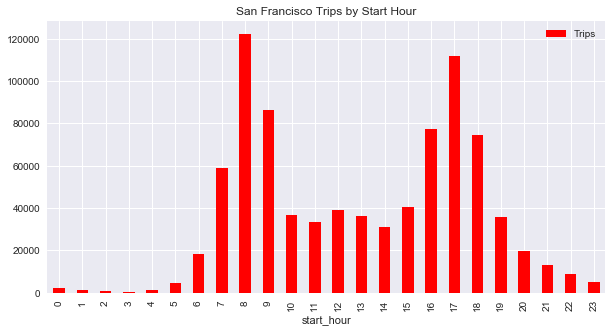

In [23]:
# plot trip duration by start hour
sf_trips.groupby(['start_hour'])['duration_minutes'].count().plot(kind='bar', color='r', figsize=(10,5))
plt.title('San Francisco Trips by Start Hour')
plt.xlabel='Start Hour'
plt.legend(['Trips'],loc='best')
plt.show()

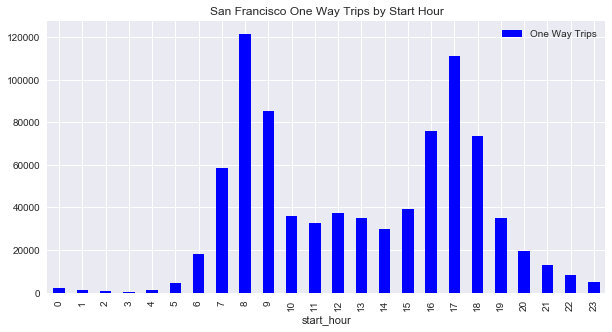

In [24]:
# plot trip duration by start hour
sf_one_way_trips.groupby(['start_hour'])['duration_minutes'].count().plot(kind='bar', color='b', figsize=(10,5))
plt.title('San Francisco One Way Trips by Start Hour')
plt.xlabel='Start Hour'
plt.legend(['One Way Trips'],loc='best')
plt.show()

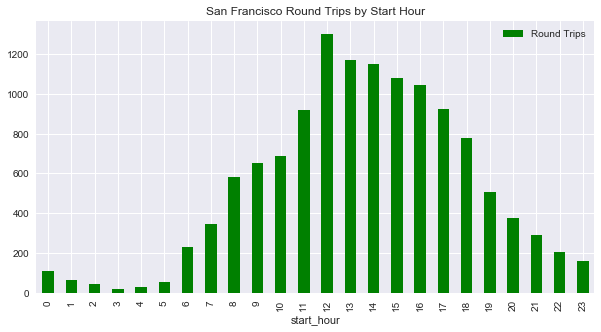

In [25]:
# plot trip duration by start hour
sf_round_trips.groupby(['start_hour'])['duration_minutes'].count().plot(kind='bar', color='g', figsize=(10,5))
plt.title('San Francisco Round Trips by Start Hour')
plt.xlabel='Start Hour'
plt.legend(['Round Trips'],loc='best')
plt.show()

### Visualize Trips that dont include San Francisco terminals

To be thurough, lets take a quick peek at non San Francisco Trips to see if these trends are similar.


In [26]:
#prune each data set to include only trips where both start and end terminals are inside San Francisco
non_sf_trips = trips.loc[~trips['start_terminal'].isin(sf_stations)].copy()
non_sf_trips = trips.loc[~trips['end_terminal'].isin(sf_stations)].copy()

non_sf_one_way_trips = one_way_trips.loc[~one_way_trips['start_terminal'].isin(sf_stations)].copy()
non_sf_one_way_trips = one_way_trips.loc[~one_way_trips['end_terminal'].isin(sf_stations)].copy()

non_sf_round_trips = round_trips.loc[~round_trips['start_terminal'].isin(sf_stations)].copy()
non_sf_round_trips = round_trips.loc[~round_trips['end_terminal'].isin(sf_stations)].copy()
print('complete')

complete


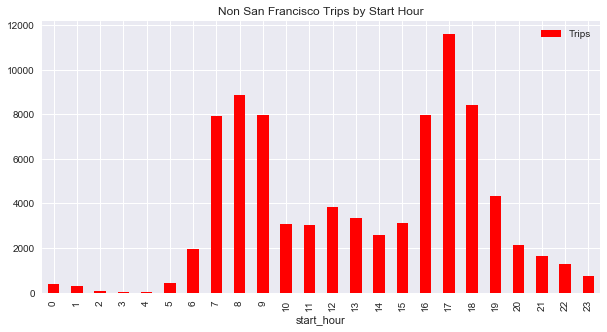

In [27]:
# plot trip duration by start hour
non_sf_trips.groupby(['start_hour'])['duration_minutes'].count().plot(kind='bar', color='r', figsize=(10,5))
plt.title('Non San Francisco Trips by Start Hour')
plt.xlabel='Start Hour'
plt.legend(['Trips'],loc='best')
plt.show()

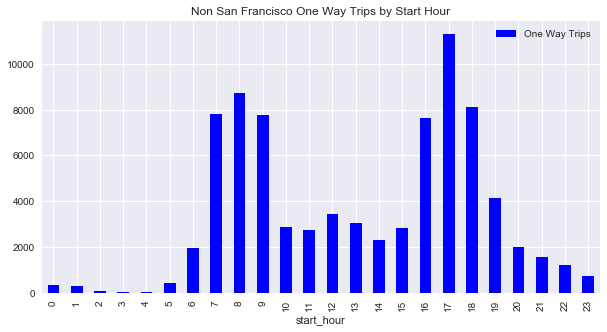

In [28]:
# plot trip duration by start hour
non_sf_one_way_trips.groupby(['start_hour'])['duration_minutes'].count().plot(kind='bar', color='b', figsize=(10,5))
plt.title('Non San Francisco One Way Trips by Start Hour')
plt.xlabel='Start Hour'
plt.legend(['One Way Trips'],loc='best')
plt.show()

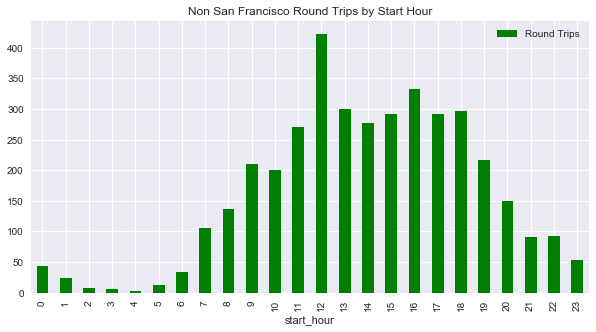

In [29]:
# plot trip duration by start hour
non_sf_round_trips.groupby(['start_hour'])['duration_minutes'].count().plot(kind='bar', color='g', figsize=(10,5))
plt.title('Non San Francisco Round Trips by Start Hour')
plt.xlabel='Start Hour'
plt.legend(['Round Trips'],loc='best')
plt.show()

### First Conlusion : Bay Area Bike Share is used by Commuters

The data set includes an entry for each ride to identify the Subscriber Type.  This is either a 'Subscriber', 'Customer', or 'NaN'.  Subscribers are riders who sign up for monthly or yearly plans so these are more likely than not the same Commuters we have identified so far. So lets test that.

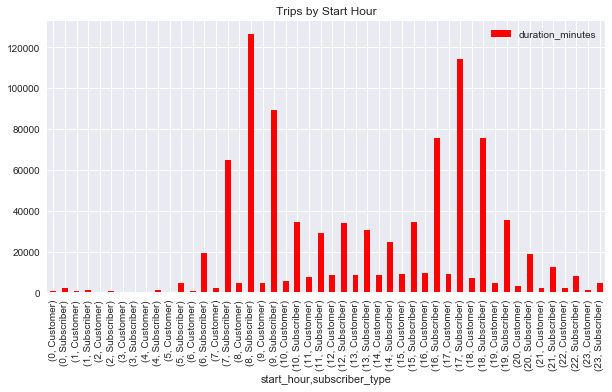

In [30]:
# plot trip start time by subscriber type
trips.groupby(['start_hour', 'subscriber_type'])['duration_minutes'].count().plot(kind='bar', color='r', figsize=(10,5))
plt.title('Trips by Start Hour')
plt.xlabel='Start Hour'
plt.legend(loc='best')
plt.show()

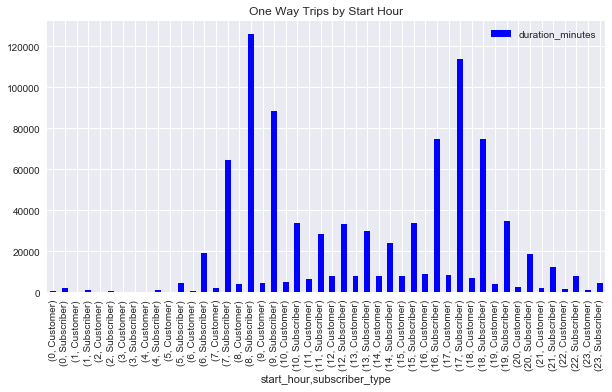

In [31]:
# plot trip start time by subscriber type
one_way_trips.groupby(['start_hour', 'subscriber_type'])['duration_minutes'].count().plot(kind='bar', color='b', figsize=(10,5))
plt.title('One Way Trips by Start Hour')
plt.xlabel='Start Hour'
plt.legend(loc='best')
plt.show()

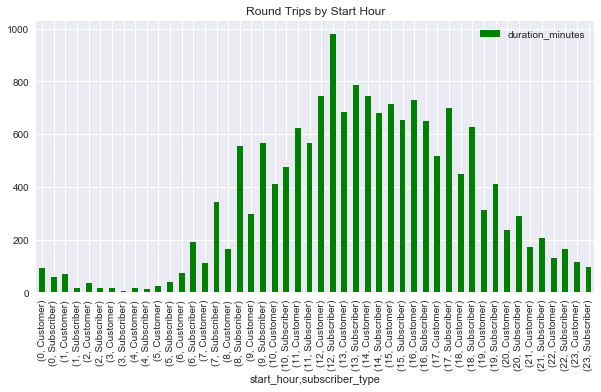

In [32]:
# plot trip start time by subscriber type
round_trips.groupby(['start_hour', 'subscriber_type'])['duration_minutes'].count().plot(kind='bar', color='g', figsize=(10,5))
plt.title('Round Trips by Start Hour')
plt.xlabel='Start Hour'
plt.legend(loc='best')
plt.show()